# Introduction to Multi-Armed Bandits

Multi-Armed Bandits is a classic problem in the field of Reinforcement Learning, where a player is faced with multiple levers or arms and must decide which arm to pull at each step, with the aim of maximizing their total reward over time. The player is faced with the trade-off between exploration and exploitation, as they must balance trying out different arms to learn their reward distribution, while also exploiting their current knowledge to choose the arm with the highest expected reward.

In this Jupyter Notebook, we will explore various algorithms used to solve the Multi-Armed Bandit problem, including Epsilon-Greedy, Upper Confidence Bound (UCB), and Boltzmann exploration. We will implement these algorithms and compare their performance on different test problems. The aim of this notebook is to provide a comprehensive understanding of the Multi-Armed Bandit problem and the various solutions available, along with practical implementation in Python. So, let's dive into the world of Multi-Armed Bandits and discover the best strategy to tackle this classic problem.

In the first step, we create a class in Python that represents a multi-armed bandit. 


In [39]:
import numpy as np

In [40]:
class BernoulliBanditEnv():
    def __init__(self, p_parameter, max_steps):
        """create a multiarm bandit with `len(p_parameter)` arms

        Args:
            p_parameter (list): list containing mean parameter of bandit arms 
            max_steps (int): number of steps for the bandit problem
        """
        assert (np.array(p_parameter) < 1).all(
        ), "Parameter p must be between 0 and 1."
        assert (0 < np.array(p_parameter)).all(
        ), "Parameter p must be between 0 and 1."
        self.p_parameter = p_parameter
        self.n_arms = len(p_parameter)
        self.max_steps = max_steps
        self.count = 0

        # to save regret statistics
        self.optimal = [max(self.p_parameter),
                        self.p_parameter.index(max(self.p_parameter))]
        self.played_optimal = 0
        self.regret = 0.0

    def step(self, action):
        assert action in range(self.n_arms), f"the action {action} is not valid"
        if np.random.uniform() < self.p_parameter[action]:
            reward = 1
        else:
            reward = 0
        self.count += 1

        # check if best action was played
        if action == self.optimal[1]:
            self.played_optimal += 1

        # update the regret in the game
        self.regret += (self.optimal[0]-reward)

        # if game is finished `done=True`
        if self.count >= self.max_steps:
            done = True
        else:
            done = False
        return 0, reward, done, {}

    def reset(self):
        self.count = 0
        self.regret = 0 
        self.played_optimal = 0 
        return


We explain all parts of the function

In [41]:
import random
import matplotlib.pyplot as plt

In [42]:
def is_positive_integer(value):
    if isinstance(value, int) and value > 0:
        return True
    return False

def is_positive_float(value):
    if isinstance(value, float) and value > 0:
        return True
    return False

def is_float_between_0_and_1(value):
    if isinstance(value, float):
        if value >= 0 and value <= 1:
            return True
    return False

In [43]:
class EpsilonGreedy():
    """ class for epsilon greedy algorithm
    """

    def __init__(self, epsilon, n_arms):
        """ initialize epsilon greedy algorithm

        Args:
            epsilon (float): epsilon parameter for the epsilon greedy algorithm
            n_arms (int): number of possible arms
        """
        assert is_positive_integer(
            n_arms), f"{n_arms} should be a positive integer"
        assert is_float_between_0_and_1(
            epsilon), f"{epsilon} should be a float between 0 and 1"
        self.epsilon = epsilon
        self.n_arms = n_arms
        self.counts = [0 for _ in range(self.n_arms)]
        self.values = [0.0 for _ in range(self.n_arms)]

    def select_arm(self):
        """ select the best arm given the estimators of the values

        Returns:
            int: best action based on the estimators of the values
        """
        if random.random() > self.epsilon:
            max_value = max(self.values)
            best_action = (self.values).index(max_value)
            return best_action
        return random.randrange(self.n_arms)

    def update(self, chosen_arm, reward):
        """ update the value estimators and counts based on the new observed
          reward and played action

        Args:
            chosen_arm (int): action which was played
            reward (float): reward of the multiarmed bandit, based on playing action `chosen_arm`
        """
        # increment the chosen arm
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        times_played_chosen_arm = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        # update via memory trick
        new_value = ((times_played_chosen_arm - 1) / float(times_played_chosen_arm)
                     ) * value + (1 / float(times_played_chosen_arm)) * reward
        self.values[chosen_arm] = new_value

    def reset(self):
        """ reset agent by resetting all required statistics
        """
        self.counts = [0 for _ in range(self.n_arms)]
        self.values = [0.0 for _ in range(self.n_arms)]

Explain all parts of the class

In [45]:
AGENT_EPSILON = 0.2
N_ARMS = 2
# probability parameter of bernoulli bandit problem
MEAN_PARAMETER = [0.1, 0.7]
MAX_STEPS = 100  # maximal gamestep
NUM_GAMES = 2  # games played of the greedy algorithm

In [46]:
num_games = NUM_GAMES
agent = EpsilonGreedy(epsilon=AGENT_EPSILON, n_arms=N_ARMS)
env = BernoulliBanditEnv(
    p_parameter=MEAN_PARAMETER, max_steps=MAX_STEPS)


chosen_arms = np.zeros(shape=(num_games, env.max_steps))
rewards = np.zeros(shape=(num_games, env.max_steps))
regrets = np.zeros(shape=(num_games, env.max_steps))
optimalities = np.zeros(shape=(num_games, env.max_steps))

In [47]:
for game in range(num_games):
        # playing the algo for `num_games` rounds
        agent.reset()
        env.reset()
        done = False
        while (not done):
            # playing the game until it is done
            action = agent.select_arm()
            _new_state, reward, done, _info = env.step(action)
            rewards[game, (env.count-1)] = reward
            chosen_arms[game, (env.count-1)] = action
            regrets[game, (env.count-1)] = env.regret
            optimalities[game, (env.count-1)] = env.played_optimal
            # update all the time 
            # IMPORTANT: different to explore then commit
            agent.update(action, reward)

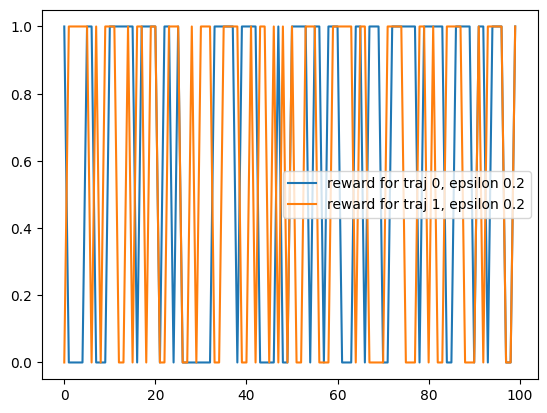

In [48]:
for i, reward in enumerate(rewards):
    plt.plot(range(len(reward)), reward,
            label=f"reward for traj {i}, epsilon {agent.epsilon}")
    plt.legend()
plt.show()

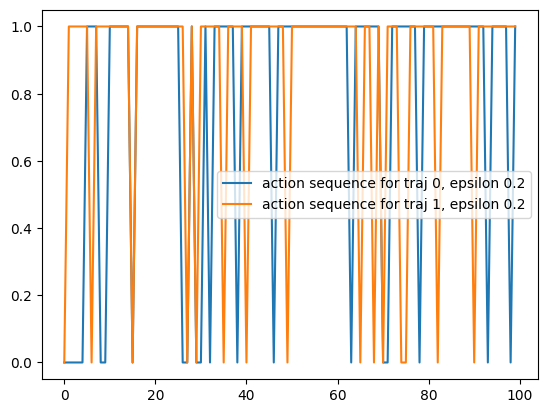

In [49]:
for i, action in enumerate(chosen_arms):
    plt.plot(range(len(action)), action,
            label=f"action sequence for traj {i}, epsilon {agent.epsilon}")
    plt.legend()
plt.show()

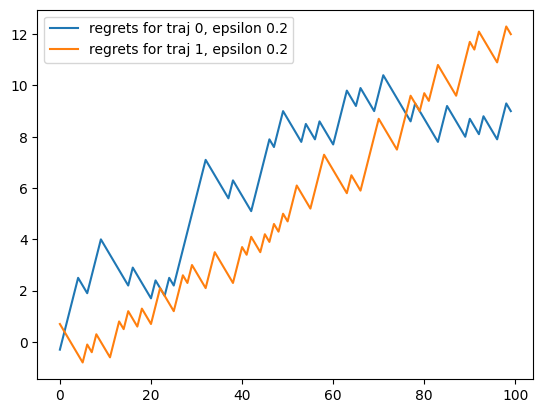

In [50]:
for i, action in enumerate(regrets):
    plt.plot(range(len(action)), action,
            label=f"regrets for traj {i}, epsilon {agent.epsilon}")
    plt.legend()
plt.show()

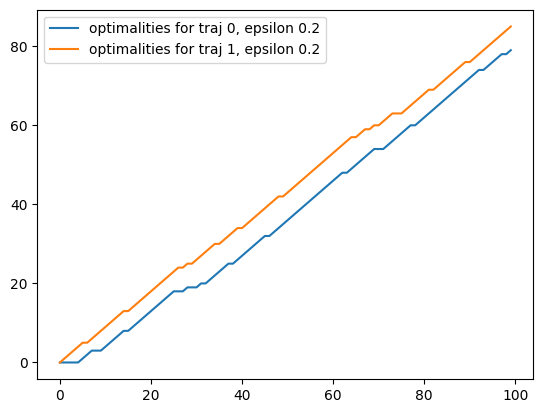

In [51]:
for i, action in enumerate(optimalities):
    plt.plot(range(len(action)), action,
            label=f"optimalities for traj {i}, epsilon {agent.epsilon}")
    plt.legend()
plt.show()

In [52]:
def train_epsilongreedy(agent, env, num_games, printed):

    chosen_arms = np.zeros(shape=(num_games, env.max_steps))
    rewards = np.zeros(shape=(num_games, env.max_steps))
    regrets = np.zeros(shape=(num_games, env.max_steps))
    optimalities = np.zeros(shape=(num_games, env.max_steps))

    for game in range(num_games):
        # playing the algo for `num_games` rounds
        agent.reset()
        env.reset()
        done = False
        while (not done):
            # playing the game until it is done
            action = agent.select_arm()
            _new_state, reward, done, _info = env.step(action)
            rewards[game, (env.count-1)] = reward
            chosen_arms[game, (env.count-1)] = action
            regrets[game, (env.count-1)] = env.regret
            optimalities[game, (env.count-1)] = env.played_optimal
            # update all the time 
            # IMPORTANT: different to explore then commit
            agent.update(action, reward)

    if printed:
        plt.subplot(4, 1, 1)
        for i, reward in enumerate(rewards):
            plt.plot(range(len(reward)), reward,
                     label=f"reward {i}, epsilon {agent.epsilon}")
            plt.legend()

        plt.subplot(4, 1, 2)
        for i, action in enumerate(chosen_arms):
            plt.plot(range(len(action)), action,
                     label=f"action sequence {i}, epsilon {agent.epsilon}")
            plt.legend()

        plt.subplot(4, 1, 3)
        for i, action in enumerate(regrets):
            plt.plot(range(len(action)), action,
                     label=f"regrets {i}, epsilon {agent.epsilon}")
            plt.legend()

        plt.subplot(4, 1, 4)
        for i, action in enumerate(optimalities):
            plt.plot(range(len(action)), action,
                     label=f"optimalities {i}, epsilon {agent.epsilon}")
            plt.legend()

        plt.show()

    return rewards, chosen_arms, regrets, optimalities

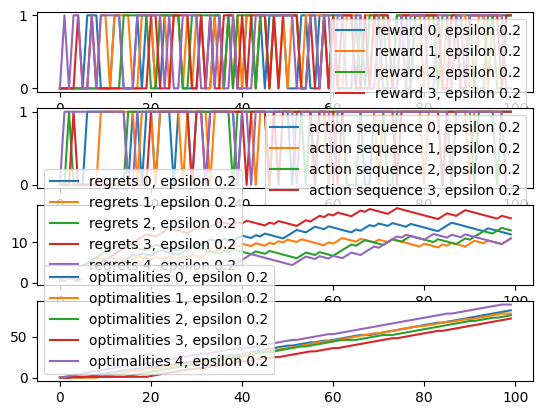

In [55]:
AGENT_EPSILON = 0.2
N_ARMS = 2
# probability parameter of bernoulli bandit problem
MEAN_PARAMETER = [0.1, 0.7]
MAX_STEPS = 100  # maximal gamestep
NUM_GAMES = 5  # games played of the greedy algorithm

agent = EpsilonGreedy(epsilon=AGENT_EPSILON, n_arms=N_ARMS)
gauss_multi_arm = BernoulliBanditEnv(
    p_parameter=MEAN_PARAMETER, max_steps=MAX_STEPS)

rewards, chosen_arms, regrets, optimalities = train_epsilongreedy(agent=agent, env=gauss_multi_arm, num_games=NUM_GAMES, printed=True)



In [60]:
MAX_STEPS = 1000
N_ARMS = 10
USED_EPSILONS = [0.1, 0.2, 0.5]
NUM_GAMES = 3000


def epsilon_greedy_exp(max_steps, n_arms, used_epsilons, num_games, printed):

    statistics_mean = {}
    statistics_cumsum = {}
    statistics_regrets = {}
    statistics_optimalities = {}

    for epsilon in used_epsilons:
        agent = EpsilonGreedy(epsilon=epsilon, n_arms=n_arms)
        rewards = np.zeros(shape=(num_games, max_steps))
        regrets = np.zeros(shape=(num_games, max_steps))
        optimalities = np.zeros(shape=(num_games, max_steps))
        for game in range(num_games):
            mean_parameter = np.random.uniform(
                low=0.0, high=1.0, size=n_arms).tolist()
            env = BernoulliBanditEnv(
                p_parameter=mean_parameter, max_steps=max_steps)
            agent.reset()
            reward, _chosen_arms, regret, optimality = train_epsilongreedy(
                agent=agent, env=env, num_games=1, printed=False)
            rewards[game,] = reward
            regrets[game,] = regret
            optimalities[game,] = optimality

        mean_rewards = np.mean(rewards, axis=0)
        mean_cum_rewards = np.cumsum(mean_rewards)
        mean_regrets = np.mean(regrets, axis=0)
        mean_optimalities = np.mean(optimalities, axis=0)
        index_array = np.arange(len(mean_optimalities))
        mean_optimalities = mean_optimalities / (index_array + 1)

        statistics_mean[str(epsilon)] = mean_rewards
        statistics_cumsum[str(epsilon)] = mean_cum_rewards
        statistics_regrets[str(epsilon)] = mean_regrets
        statistics_optimalities[str(epsilon)] = mean_optimalities

        # print statistics in console
        print(50*"*")
        print(
            f"total mean reward with epsilon= {epsilon} is {mean_cum_rewards[-1]}")
        print(
            f"total regret with epsilon= {epsilon} is {mean_regrets[-1]}")
        print(
            f"total optimality with epsilon= {epsilon} is {mean_optimalities[-1]}")
        print(50*"*")

    if printed:
        plt.subplot(4, 1, 1)
        for used_epsi, traj in statistics_mean.items():
            plt.plot(range(len(traj)), traj,
                     label=f"mean reward, epsilon {used_epsi}")
            plt.legend()
        plt.subplot(4, 1, 2)
        for used_epsi, traj in statistics_cumsum.items():
            plt.plot(range(len(traj)), traj,
                     label=f"cumsum reward, ep {used_epsi}")
            plt.legend()
        plt.subplot(4, 1, 3)
        for used_epsi, traj in statistics_regrets.items():
            plt.plot(range(len(traj)), traj,
                     label=f"regrets, ep {used_epsi}")
            plt.legend()
        plt.subplot(4, 1, 4)
        for used_epsi, traj in statistics_optimalities.items():
            plt.plot(range(len(traj)), traj,
                     label=f"optimalities, ep {used_epsi}")
            plt.legend()
        plt.show()

    return statistics_mean, statistics_cumsum, statistics_regrets, statistics_optimalities



**************************************************
total mean reward with epsilon= 0.1 is 838.02
total regret with epsilon= 0.1 is 71.27585416510334
total optimality with epsilon= 0.1 is 0.653931
**************************************************
**************************************************
total mean reward with epsilon= 0.2 is 809.946666666667
total regret with epsilon= 0.2 is 99.44611960432825
total optimality with epsilon= 0.2 is 0.6279089999999999
**************************************************
**************************************************
total mean reward with epsilon= 0.5 is 697.3570000000001
total regret with epsilon= 0.5 is 212.2532631961485
total optimality with epsilon= 0.5 is 0.44714666666666664
**************************************************


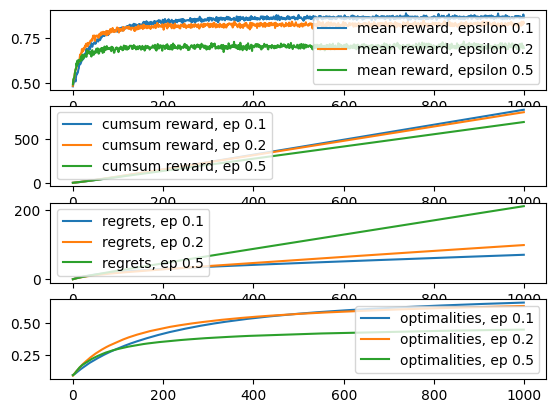

In [61]:
statistics_mean, statistics_cumsum, statistics_regrets, statistics_optimalities = epsilon_greedy_exp(max_steps=MAX_STEPS, n_arms=N_ARMS,
                          used_epsilons=USED_EPSILONS, num_games=NUM_GAMES, printed=True)
